# Is That a Supra? <br>
## 불면증때문에 술마셨는데 취해서만드는 Supra Classifier <br>
### Is that a Supra? 란?
외국 밈(meme) 중 Supra라는 차량을 발견하면 Is that a Supra? 라고 하는것에서 착안함. <a href="https://www.youtube.com/watch?v=ybZmYvaqwEg">youtube 영상</a>

## * 이미지 크롤링 <br>
### 신경망은 ResNet50을 사용할 것이기 때문에 그렇다 해도 일단 Supra이미지를 구글 이미지에서 가져와야한다. <br>

고마워요 <a href="https://blog.naver.com/fkdldjs60/222161730266">인터넷!</a>

In [22]:
from urllib.request import urlretrieve
from urllib.parse import quote_plus
from urllib.error import HTTPError
import urllib
from selenium import webdriver
import time
import socket
import os
import ssl


def crawler(search, num_img=300, img_format="jpg", timeout=30):
    print("Start crawling : " + search)
    url = f'https://www.google.com/search?q={quote_plus(search)}&source=lnms&tbm=isch&sa=X&ved=2ahUKEwiYz_K9kfPtAhXQfd4KHQQoDxEQ_AUoAXoECAYQAw'

    driver = webdriver.Chrome()
    driver.get(url)
    driver.maximize_window()

    # Scrolling
    last_height = driver.execute_script("return document.body.scrollHeight")
    while True:
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight)")
        time.sleep(2)
        new_height = driver.execute_script("return document.body.scrollHeight")
        if new_height == last_height:
            try:
                driver.find_element_by_css_selector(".mye4qd").click()
            except:
                break
        last_height = new_height

    os.makedirs(search, exist_ok=True)

    images = driver.find_elements_by_css_selector(".rg_i.Q4LuWd")
    print(len(images))
    count = 1

    # Download images.
    for image in images:
        try:
            if count < 458:
                count = count + 1
            else:
                try:
                    driver.execute_script("arguments[0].click();", image)
                    time.sleep(2)
                    imgUrl = driver.find_element_by_xpath(
                        '//*[@id="Sva75c"]/div/div/div[3]/div[2]/c-wiz/div[1]/div[1]/div/div[2]/a/img').get_attribute("src")
                    opener = urllib.request.build_opener()
                    opener.addheaders = [('User-agent',
                                      'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.88 Safari/537.36')]
                    urllib.request.install_opener(opener)
                
                    socket.setdefaulttimeout(timeout)
                    urllib.request.urlretrieve(imgUrl, search + "/" + str(count) + '.' + img_format)
                except socket.timeout:
                    print("Request timed out.")
                    pass
                
                except ssl.SSLCertVerificationError:
                    pass

                print(str(count) + "th image is downloaded.")
                count = count + 1
                
            if count == num_img + 1:
                break
        except HTTPError:
            print("Http response not good.")
            pass
        
        



In [23]:
#crawler("toyota supra photo", img_format='png', num_img=700)
crawler("car photo", img_format='png', num_img=700)

Start crawling : car photo
785
458th image is downloaded.
459th image is downloaded.
460th image is downloaded.
461th image is downloaded.
462th image is downloaded.
463th image is downloaded.
464th image is downloaded.
465th image is downloaded.
466th image is downloaded.
467th image is downloaded.
468th image is downloaded.
469th image is downloaded.
470th image is downloaded.
471th image is downloaded.
472th image is downloaded.
473th image is downloaded.
474th image is downloaded.
475th image is downloaded.
476th image is downloaded.
477th image is downloaded.
478th image is downloaded.
479th image is downloaded.
480th image is downloaded.
481th image is downloaded.
482th image is downloaded.
483th image is downloaded.
484th image is downloaded.
485th image is downloaded.
486th image is downloaded.
487th image is downloaded.
488th image is downloaded.
489th image is downloaded.
490th image is downloaded.
491th image is downloaded.
492th image is downloaded.
493th image is downloade

In [1]:
import numpy as np
import os
import PIL
from PIL import Image
from PIL import ImageFile
import tensorflow as tf
import pathlib
import glob

ImageFile.LOAD_TRUNCATED_IMAGES = True

c:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
c:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
# 이미지 format 맞춰주기
def format_convert():
    count = 1
    for file in glob.glob("./data/*/*/*.png"):
        print(count)
        im = Image.open(file)
        rgb_im = im.convert('RGB')
        rgb_im.save(file.replace("png", "jpg"), quality=95)
        im.close()
        os.remove(file)
        count += 1


In [3]:
format_convert()

1
2
3
4


c:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\PIL\Image.py:952: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279


In [1]:
# Import libraries.
import os
import cv2
import numpy as np
from sklearn.utils import shuffle
from random import randint

import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from PIL import Image
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras import applications

c:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
c:\program files (x86)\microsoft visual studio\shared\python37_64\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
os.environ["TF_FROCE_GPU_ALLOW_GROWTH"] = "true"

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [25]:
def get_image(DIR):
    Images = []
    Labels = []
    label = 0
    
    for labels in os.listdir(DIR):
        if labels == 'supra':
            label = 1
        elif labels == 'other':
            label = 0
            
        for image_file in os.listdir(DIR + labels):
            image = cv2.imread(DIR + labels + r'/' + image_file)
            image = cv2.resize(image, (200, 200))
            Images.append(image)
            Labels.append(label)
            
        
    return shuffle(Images, Labels, random_state=20210108)
    

def get_classlabel(class_code):
    labels = {
        0 : 'other',
        1 : 'supra',
    }
    return labels[class_code]

In [4]:
Images, Labels = get_image('./data/train/')

Images = np.array(Images, dtype=np.float32)
Images = Images / 255.0
Labels = np.array(Labels)

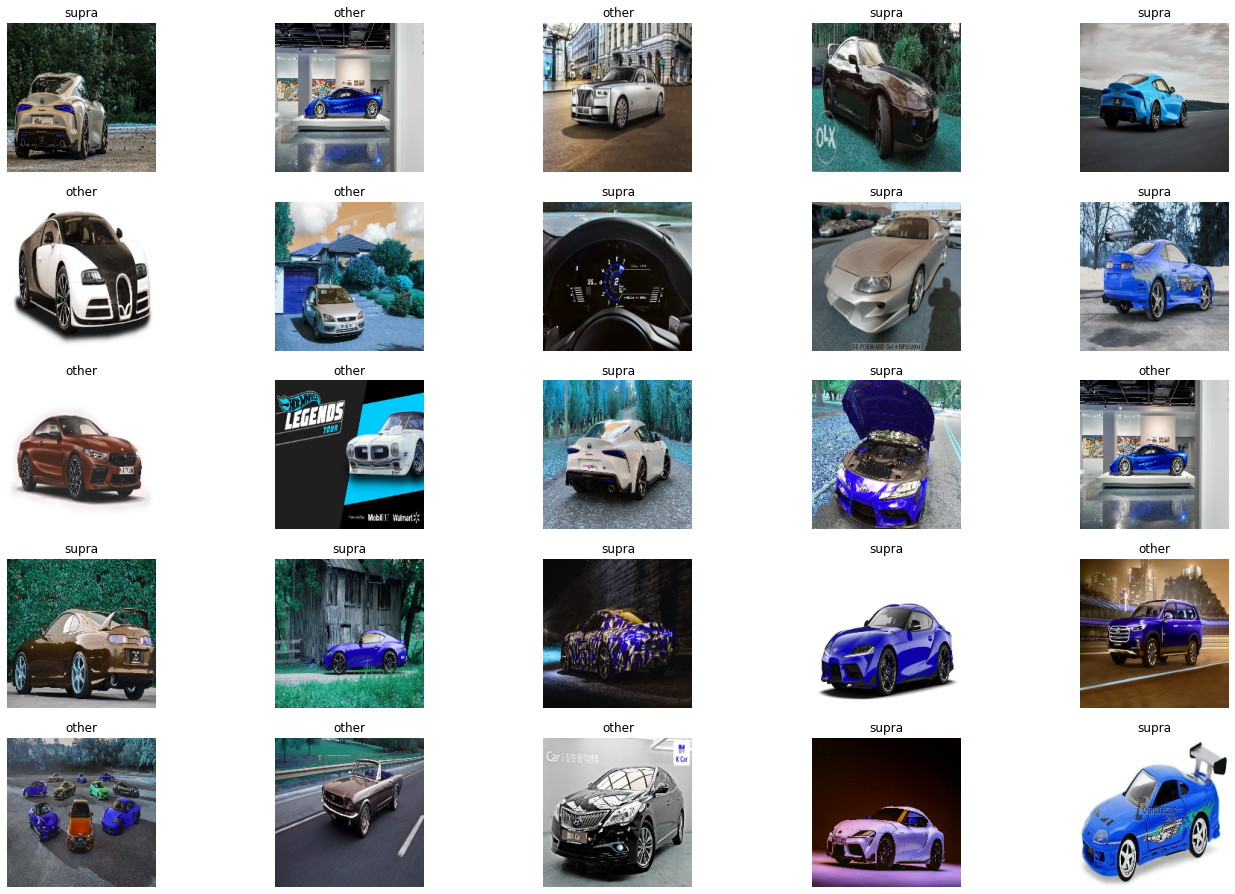

In [5]:
# Image plot
f, ax = plt.subplots(5, 5)
f.subplots_adjust(0,0,3,3)
for i in range(0, 5, 1):
    for j in range(0, 5, 1):
        rand_num = randint(0, len(Images))
        ax[i, j].imshow(Images[rand_num])
        ax[i, j].set_title(get_classlabel(Labels[rand_num]))
        ax[i, j].axis('off')

In [3]:
TRAIN_BATCH_SIZE = 32
VAL_BATCH_SIZE = 128

# Image augmentation
train_DIR = "./data/train"

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.1,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory (
    train_DIR,
    batch_size=TRAIN_BATCH_SIZE,
    class_mode='binary',
    target_size=(200, 200),
)

val_DIR = "./data/valid"

val_datagen = ImageDataGenerator (
    rescale=1.0 / 255,
)

val_generator = val_datagen.flow_from_directory (
    val_DIR,
    batch_size=VAL_BATCH_SIZE,
    class_mode='binary',
    target_size=(200, 200),
)

Found 717 images belonging to 2 classes.
Found 240 images belonging to 2 classes.


In [15]:
base_model = applications.InceptionResNetV2 (
    input_shape=(200, 200, 3),
    include_top=False,
)

for layer in base_model.layers:
    layer.trainable = False

In [16]:
base_output =  base_model.output
x = tf.keras.layers.Flatten()(base_output)
x = tf.keras.layers.Dense(units=1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(base_model.input, x)

In [17]:
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_acc',
    patience=2,
    verbose=1,
    factor=0.3,
    min_lr=0.0000003,
)

early_stop = EarlyStopping(
    monitor='loss', patience=3,
)

In [18]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 99, 99, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 99, 99, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 99, 99, 32)   0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [19]:
model.compile (
    optimizer='Adam',
    loss='binary_crossentropy',
    metrics=['acc']
)

In [20]:
history = model.fit(
    train_generator,
    epochs=50,
    verbose=1,
    validation_data=val_generator,
    callbacks=[learning_rate_reduction, early_stop]
)

Epoch 1/50
23/23 [==============================] - 25s 736ms/step - loss: 17.1338 - acc: 0.5764 - val_loss: 6.0081 - val_acc: 0.7125
Epoch 2/50
23/23 [==============================] - 10s 437ms/step - loss: 6.0947 - acc: 0.6558 - val_loss: 6.1681 - val_acc: 0.6125
Epoch 3/50
23/23 [==============================] - 10s 434ms/step - loss: 3.2120 - acc: 0.6447 - val_loss: 1.1976 - val_acc: 0.7042

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 4/50
23/23 [==============================] - 10s 441ms/step - loss: 1.2131 - acc: 0.6818 - val_loss: 0.8122 - val_acc: 0.7333
Epoch 5/50
23/23 [==============================] - 10s 437ms/step - loss: 1.0137 - acc: 0.7000 - val_loss: 0.5744 - val_acc: 0.7292
Epoch 6/50
23/23 [==============================] - 10s 436ms/step - loss: 0.6246 - acc: 0.7318 - val_loss: 0.5386 - val_acc: 0.7208

Epoch 00006: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
Epoch 7/50
23/23 [=====================

In [21]:
# 이제 metrics를 시각화 하자.
def plot_metrics(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

## InceptionResNetV2
- 성능이 매우 안좋다. Train metric뿐만아니라 Validation metric도 매우 안좋다.

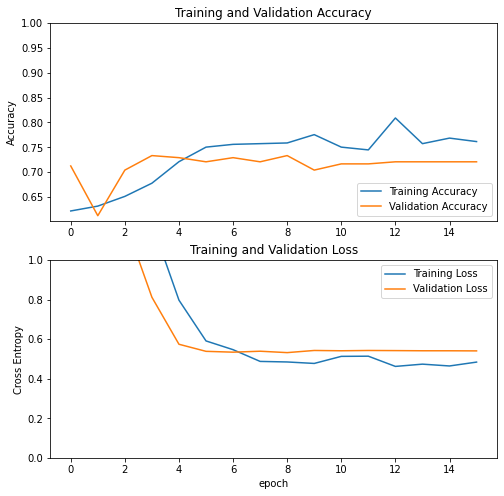

In [22]:
plot_metrics(history)

## 예측 결과
- 테스트데이터에서 약 50퍼센트의 적중률을 보여준다. 데이터셋이 잘못되었을 가능성이 높긴하지만 모델을 간단한 모델을 사용해야될거같다.

Test Accuracy : 0.5041666666666667


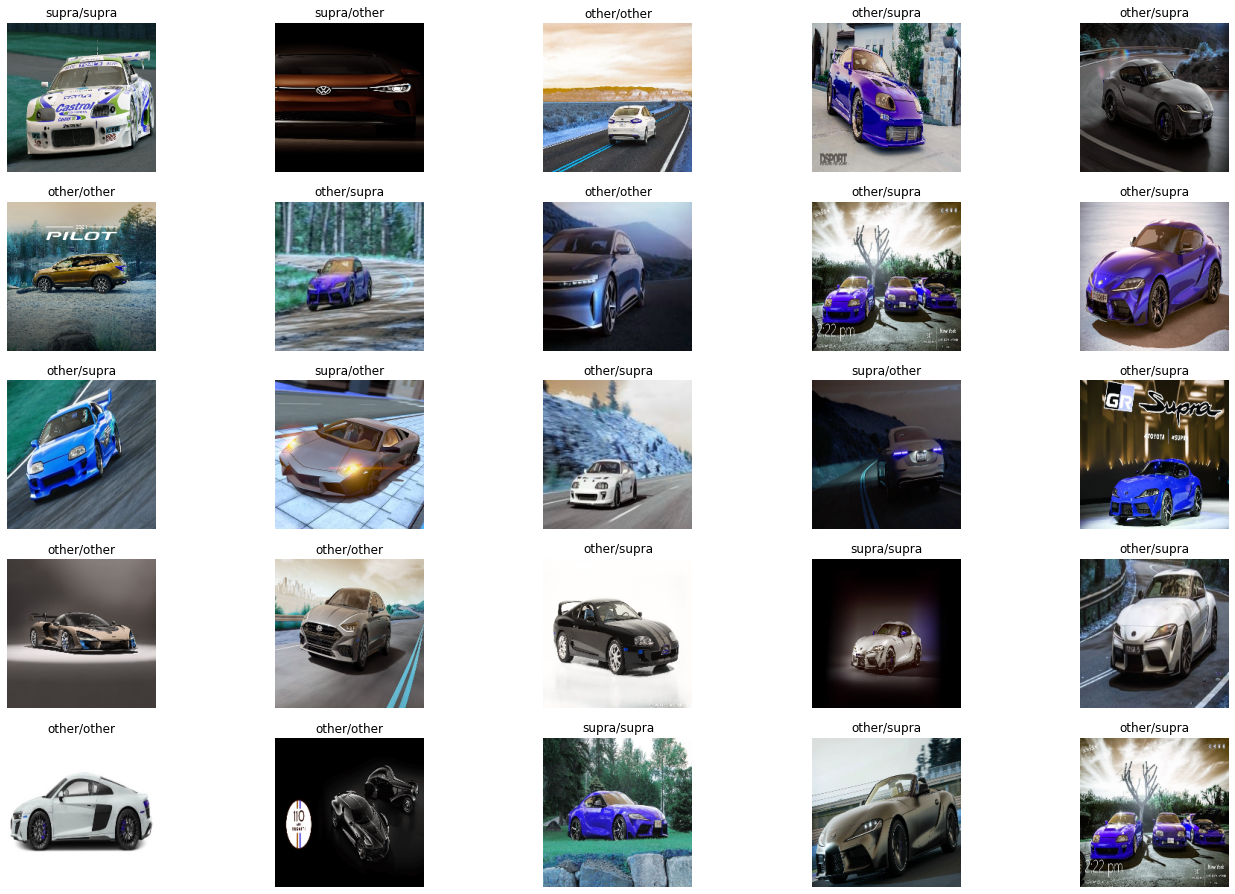

In [46]:
import numpy as np
from keras.preprocessing import image
    
test_Images, test_Labels = get_image('./data/test/')    

count = 0

f, ax = plt.subplots(5, 5)
f.subplots_adjust(0,0,3,3)
for i in range(0, 5, 1):
    for j in range(0, 5, 1):
        rand_num = randint(0, len(test_Images))
        ax[i, j].imshow(test_Images[rand_num])
        test_Image = image.img_to_array(test_Images[rand_num])
        test_Image = np.expand_dims(test_Image, axis = 0)
        result = model.predict(test_Image)
        
        if result > 0.5:
            label = "supra"
        else:
            label = "other"
        
        ax[i, j].set_title(label + "/" + get_classlabel(test_Labels[rand_num]))
        ax[i, j].axis('off')
        
        
for i in range(len(test_Images)):
    img = image.img_to_array(test_Images[i])
    img = np.expand_dims(img, axis=0)
    result = model.predict(img)
    if result > 0.5:
            label = "supra"
    else:
            label = "other"
            
    if label == get_classlabel(test_Labels[i]):
        count += 1
        
        
print("Test Accuracy : " + str(count / len(test_Images)))

## InceptionResNetV2
- generator를 안쓰고돌리면 심하게 overfitting이 나고 Generator를 사용하면 그냥 성능이 안좋아진다.
- 미리 학습된 네트워크말고 내가 직접 쌓아서 네트워크 규모를 줄인 다음에 generator없이 학습시켜야 할 것 같다.